# introducción

Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

El objetivo de este analisis es evaluar la efectividad de las pruebas A/B realizadas por el equipo anterior, para asi determinar si hubo diferencias significativas en el comportamiento de los usuarios entre los grupos A y B en las pruebas que se mencionan:

- recommender_system_test
- interface_eu_test

Tambien se debe analizar la influencia de campañas de marketing al probar cambios relacionados con la introducción de un sistema de recomendaciones mejorada y evaluar la distribución geográfica, dispositivo utilizado y actividad para detectar posibles sesgos en la asignación de grupos.

In [1]:
# Cargamos todas las librerías
import pandas as pd
import numpy as np
import math as mt 
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
import plotly.express as px 
from scipy import stats as st
from math import factorial
from statsmodels.stats.proportion import proportions_ztest

In [2]:
#Leemos todos los dataframes y los asignamos en variables
ab_project = pd.read_csv('/datasets/ab_project_marketing_events_us.csv',sep=',')
ab_new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv',sep=',')
ab_events = pd.read_csv('/datasets/final_ab_events_upd_us.csv',sep=',')
ab_participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv',sep=',')

# Explorando los datos

In [3]:
#Hechamos un vistazo rapido a 'ab_project'
ab_project.info()
print()
print(ab_project.head())
print()
print(ab_project.isna().sum())
print()
print(ab_project.describe())
print()
# Encontramos duplicados considerando todas las columnas
print("Valores duplicados: ", ab_project.duplicated(subset=ab_project.columns, keep=False).sum())  # keep=False marca todos los duplicado


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

                           name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11  

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

        

deacuerdo al vistazo rápido de nuestro dataframe project, podemos observar que no tenemos valores ausentes ni duplicados, sin embargo, para cuestiones de análisis en los siguientes pasos, debemos cambiar el tipo de datos para las columnas 'start_dt' y 'finish_dt' ya que se encuentran en tipo Objeto

In [4]:
#Hechamos un vistazo rapido a 'ab_new_users'
ab_new_users.info()
print()
print(ab_new_users.head())
print()
print(ab_new_users.isna().sum())
print()
print(ab_new_users.describe())
print()
# Encontramos duplicados considerando todas las columnas
print("Valores duplicados: ", ab_new_users.duplicated(subset=ab_new_users.columns, keep=False).sum())  # keep=False marca todos los duplicado


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB

            user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone

user_id       0
first_date    0
region        0
device        0
dtype: int64

                 user_id  first_date region   device
count              58703       58703  58703    58703
unique             58703          17      4        4
top     3B9646C78ABD0730  2020-12-21     EU  Android
freq    

deacuerdo al vistazo rápido de nuestro dataframe ab_new_users, podemos observar que no tenemos valores ausentes ni duplicados, sin embargo, para cuestiones de análisis en los siguientes pasos, debemos cambiar el tipo de datos para la columna 'first_date' ya que se encuentra en tipo Objeto

In [5]:
#Hechamos un vistazo rapido a 'ab_events'
ab_events.info()
print()
print(ab_events.head())
print()
print(ab_events.isna().sum())
print()
print(ab_events.describe())
print()
# Encontramos duplicados considerando todas las columnas
print("Valores duplicados: ", ab_events.duplicated(subset=ab_events.columns, keep=False).sum())  # keep=False marca todos los duplicado

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB

            user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457  2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

            details
count  60314.000000
mean      23.881219
std       72.228884
min        4.990000
25%        4.990000

hechando un vistazo rapido al dataframe de ab_events, la columna 'details' tiene 363,447 valores ausentes, sin embargo, notamos que cuando el evento no es purchase, no cuenta con registo ya que no se concretó una compra.

Hay que cambiar los tipos de datos a fechas para la columna 'event_dt'

In [6]:
#Hechamos un vistazo rapido a 'ab_participants'
ab_participants.info()
print()
print(ab_participants.head())
print()
print(ab_participants.isna().sum())
print()
print(ab_participants.describe())
print()
# Encontramos duplicados considerando todas las columnas
print("Valores duplicados: ", ab_participants.duplicated(subset=ab_participants.columns, keep=False).sum())  # keep=False marca todos los duplicado


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB

            user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  4FF2998A348C484F     A  recommender_system_test

user_id    0
group      0
ab_test    0
dtype: int64

                 user_id  group            ab_test
count              14525  14525              14525
unique             13638      2                  2
top     DDCEDA0705FF68FB      A  interface_eu_test
freq                   2   8214              10850

Valores duplicados:  0


deacuerdo al vistazo rápido de nuestro dataframe ab_participants, podemos observar que no tenemos valores ausentes ni duplicados
Sin embargo, el metodo Describe() nos arrojó duplicados en user_id: 14,525 de datos totales vs 13,638 user_id únicos. 
Probablemente los usuarios participaron en múltiples pruebas con diferente grupo, eso puede contaminar nuestros resultados.
Vamos a analizar esto mas adelante.

In [7]:
# Convertimos a datetime
ab_project['start_dt'] = pd.to_datetime(ab_project['start_dt'])
ab_project['finish_dt'] = pd.to_datetime(ab_project['finish_dt'])
ab_new_users['first_date'] = pd.to_datetime(ab_new_users['first_date'])
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])

In [8]:
# Identificamos duplicados por user_id y group
duplicates_group = ab_participants.groupby(['user_id', 'group']).size().reset_index(name='counts')
duplicates_group = duplicates_group[duplicates_group['counts'] > 1]
print(f"Usuarios duplicados en el mismo grupo: {len(duplicates_group)}")
print(duplicates_group)

# Identificamos duplicados por user_id y ab_test
duplicates_ab = ab_participants.groupby(['user_id', 'ab_test']).size().reset_index(name='counts')
duplicates_ab = duplicates_ab[duplicates_ab['counts'] > 1]
print(f"Usuarios duplicados en la prueba: {len(duplicates_ab)}")


Usuarios duplicados en el mismo grupo: 446
                user_id group  counts
1      001064FEAAB631A1     B       2
8      00341D8401F0F665     A       2
43     00EFA157F7B6E1C4     A       2
83     01B9975CAE144B78     A       2
96     020A95B66F363AFB     B       2
...                 ...   ...     ...
13881  FC37CBE8211E02A8     B       2
13916  FCF70F6E1871BD78     A       2
14004  FE82D7FC50D4155B     A       2
14045  FF2174A1AA0EAD20     A       2
14050  FF44696E39039D29     A       2

[446 rows x 3 columns]
Usuarios duplicados en la prueba: 0


Una vez analizados los datos que notamos en 'participants', notamos que agrupando por prueba no tenemos duplicados y de los 446 duplicados que se encontrarón al agrupar por grupo son usuarios en diferentes pruebas, esto no afecta los resultados ya que se encuentran en pruebas distintas, no hay necesidad de eliminarlos y 446 refleja menos de un 5% de nuestros datos totales (+14,000 registros)

# Análisis exploratorio de datos

Primero, necesitamos identificar las etapas del embudo de conversión. estas se encuentran en Events:

In [9]:
print(ab_events['event_name'].value_counts())

login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: event_name, dtype: int64


como podemos ver, el embudo de conversión tendra las siguientes etapas: login, product_page, product_cart, purchase

In [10]:
# Combinamos dataframes 'ab_events, ab_participants y ab_new_users' para análisis mas sencillo
users_events = ab_events.merge(ab_participants, on='user_id')
users_events = users_events.merge(ab_new_users, on='user_id')

# Identificamos los eventos relevantes en el embudo y los filtramos
funnel_events = ['login', 'product_page', 'product_cart', 'purchase']
funnel_data = ab_events[ab_events['event_name'].isin(funnel_events)]

print(funnel_data)

                 user_id            event_dt event_name  details
0       E1BDDCE0DAFA2679 2020-12-07 20:22:03   purchase    99.99
1       7B6452F081F49504 2020-12-07 09:22:53   purchase     9.99
2       9CD9F34546DF254C 2020-12-07 12:59:29   purchase     4.99
3       96F27A054B191457 2020-12-07 04:02:40   purchase     4.99
4       1FD7660FDF94CA1F 2020-12-07 10:15:09   purchase     4.99
...                  ...                 ...        ...      ...
423756  245E85F65C358E08 2020-12-30 19:35:55      login      NaN
423757  9385A108F5A0A7A7 2020-12-30 10:54:15      login      NaN
423758  DB650B7559AC6EAC 2020-12-30 10:59:09      login      NaN
423759  F80C9BDDEA02E53C 2020-12-30 09:53:39      login      NaN
423760  7AEC61159B672CC5 2020-12-30 11:36:13      login      NaN

[423761 rows x 4 columns]


In [11]:
# Contamos el número de usuarios en cada etapa del embudo
funnel_conversion = funnel_data.groupby('event_name')['user_id'].nunique().reset_index()
funnel_conversion.columns = ['event_name', 'unique_users']

# Ordenamos los eventos según el orden del embudo
funnel_conversion['event_name'] = pd.Categorical(funnel_conversion['event_name'], categories=funnel_events, ordered=True)
funnel_conversion = funnel_conversion.sort_values('event_name')

# Calculamos la conversión entre etapas Y usamos pct_change para calcular cuánto cambia el número de usuarios entre cada etapa del embudo
funnel_conversion['conversion_rate'] = funnel_conversion['unique_users'].pct_change() * 100 
funnel_conversion['conversion_rate'].fillna(100, inplace=True) 

print(funnel_conversion)

     event_name  unique_users  conversion_rate
0         login         58696       100.000000
2  product_page         38929       -33.676912
1  product_cart         19284       -50.463665
3      purchase         19568         1.472724


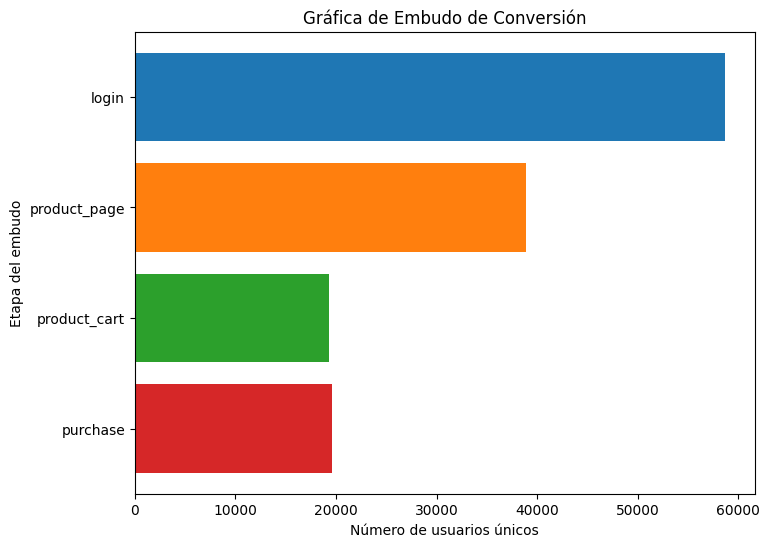

In [12]:
funnel_conversion = {
    'event_name': ['login', 'product_page', 'product_cart', 'purchase'],
    'unique_users': [58696, 38929, 19284, 19568]
}

# Creamos una grafica de embudo
plt.figure(figsize=(8, 6))
plt.barh(funnel_conversion['event_name'], funnel_conversion['unique_users'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.xlabel("Número de usuarios únicos")
plt.ylabel("Etapa del embudo")
plt.title("Gráfica de Embudo de Conversión")
plt.gca().invert_yaxis()  # Invierte el eje y para que el embudo tenga el flujo lógico de arriba a abajo
plt.show()

Deacuerdo al resultado mostrado, podemos analizar que:
- **Login:** 58,696 usuarios únicos completaron esta etapa. Al ser la primera etapa, la tasa de conversión es del 100%, osease, todos los usuarios pasan por aqui.

- **Product_page:** 38,929 usuarios unicos llegaron a esta etapa, la tasa de conversion del -33.68% nos indica que aproximadamente el 33.68% de los usuarios que se registraron no llegaron a ver una página de producto. Quiza tuvieron una mala experiencia con la pagina, por lo cual no pudieron navegar o simplemente perdieron interés.

- **Product_cart:** 19,284 usuarios únicos añadieron un producto al carrito. La tasa de conversión es -50.46% nos dice que casi la mitad de los usuarios que vieron una página de producto no añadieron un producto al carrito. De nuevo, esto nos dice que quiza tuvieron problemas tecnicos con la pagina o simplemente los productos se les hicieron caros.

- **Purchase:** 19,568 usuarios únicos realizaron una compra. La tasa de conversión es 1.47% lo cual nos dice que solo un pequeño porcentaje de los usuarios que añadieron un producto al carrito completaron la compra. Quiza algunos usuarios no añadieron el producto al carrito, si no que compraron directamente.


# ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

        count     mean       std  min  25%  50%  75%   max
group                                                     
A      7874.0  7.45555  4.475159  1.0  4.0  6.0  9.0  40.0
B      6205.0  7.11249  4.246201  1.0  4.0  6.0  9.0  36.0


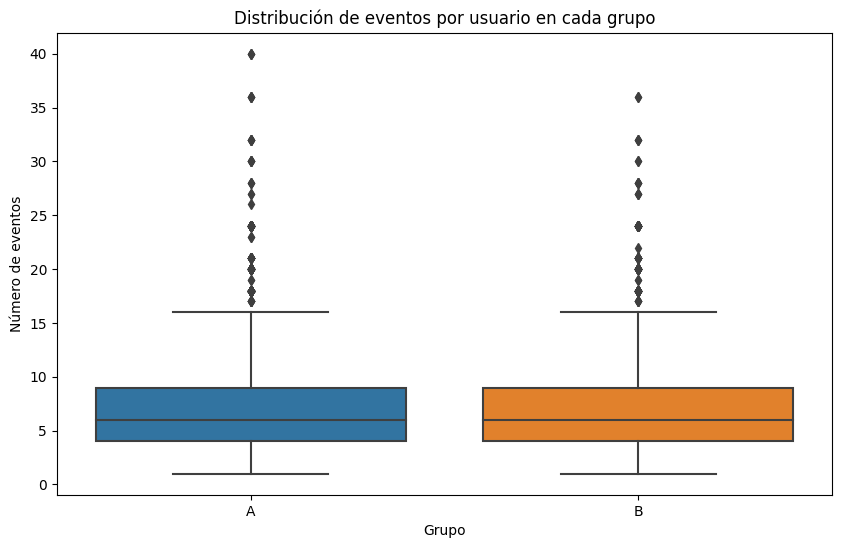

In [13]:
# hacemos un filtro con los datos de eventos de los participantes de la prueba
events_with_group = pd.merge(ab_events, ab_participants, on='user_id', how='inner')

# Contamos el número de eventos por usuario y comparamos la distribucion de eventos
events_per_user = events_with_group.groupby(['user_id', 'group']).size().reset_index(name='event_count')
group_event_dist = events_per_user.groupby('group')['event_count']

print(group_event_dist.describe())

plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='event_count', data=events_per_user)
plt.title('Distribución de eventos por usuario en cada grupo')
plt.xlabel('Grupo')
plt.ylabel('Número de eventos')
plt.show()

deacuerdo al analisis que hicimos, el grupo A tiene 7,874 usuarios, mientras que el grupo B tiene 6,205 usuarios. Esto nos dice que el grupo A es ligeramente más grande que el grupo B. Sin embargo, esta diferencia no es significativamente grande, por lo que no debería ser un problema significativo para el análisis.

In [14]:
# como extra, clasificamos dispositivos en mobile y desktop
desktop = ['PC', 'Mac']
mobile = ['iPhone', 'Android']


users_events['device_type'] = users_events['device'].apply(
    lambda x: 'Mobile' if x in mobile else 'Desktop'
)

# Calculamos tasas de conversión por dispositivo
funnel_device_conv = (
    users_events.groupby(['device_type', 'event_name'])['user_id']
    .nunique()
    .unstack(fill_value=0)
    .T
)

funnel_device_conv = (funnel_device_conv / funnel_device_conv.loc['login']) * 100

print(funnel_device_conv)

device_type      Desktop      Mobile
event_name                          
login         100.000000  100.000000
product_cart   32.707775   31.956299
product_page   65.394927   65.460339
purchase       33.429573   33.481279


deacuerdo a estos resultados podemos observar que las diferencias de conversiones entre movil y desktop son minimas en cada una de las etapas/eventos

# ¿Hay usuarios que están presentes en ambas muestras?

In [15]:
#creamos un filtro que contiene la diferencia de usuario en cada prueba
users_diff = users_events.groupby(["user_id", "ab_test"])["group"].nunique()
users_diff = users_diff[users_diff > 1].reset_index()

print(f"Usuarios en ambos grupos de la misma prueba: {len(users_diff)}")

Usuarios en ambos grupos de la misma prueba: 0


# ¿Cómo se distribuye el número de eventos entre los días?

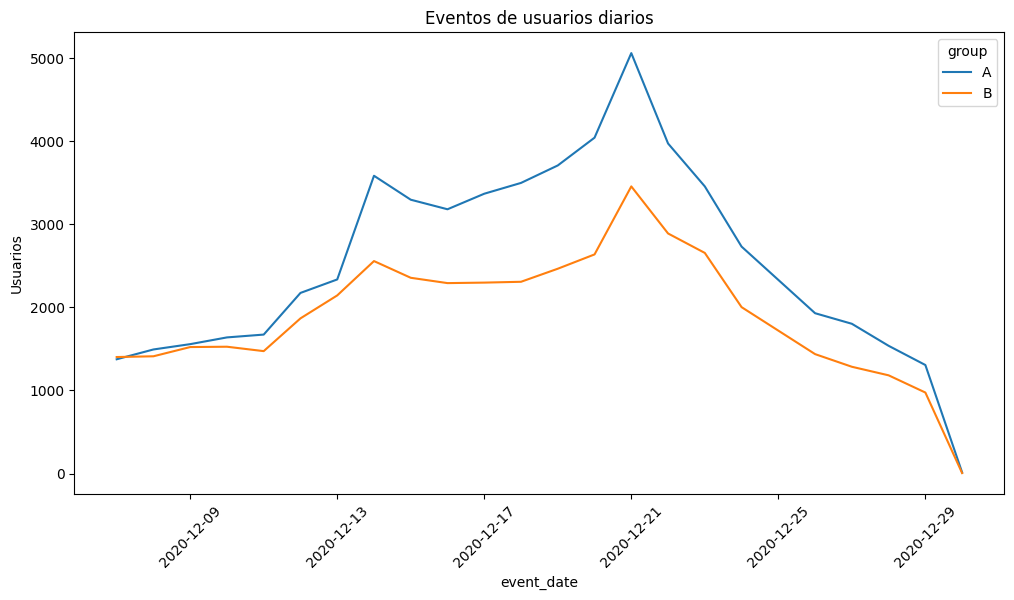

In [16]:
# Convertimos event_dt a datetime y extraemos fecha
users_events["event_date"] = pd.to_datetime(users_events["event_dt"]).dt.date

# creamos un filtro de eventos por día y grupo
ab_daily_events = users_events.groupby(["event_date", "group"]).size().reset_index(name="Usuarios")

plt.figure(figsize=(12, 6))
sns.lineplot(x="event_date", y="Usuarios", hue="group", data=ab_daily_events)
plt.title("Eventos de usuarios diarios")
plt.xticks(rotation=45)
plt.show()

La siguiente gráfica nos muestra la distribución del número de eventos de usuario diarios para los grupos A y B a lo largo del tiempo.Podemos observar que ambos grupos muestran un crecimiento en el número de eventos desde el inicio del periodo hasta alrededor del 21 de diciembre, siendo este dia el pico mas grande de actividad, siendo mas alto en el Grupo A y despues caen considerablemente.
Esto nos dice que quiza por las fechas, las compras de ultimo momento son mayores este dia por las fechas festivas siguientes, y posterior a esta fecha ya no hay tantas compras.

# ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

In [17]:
# Verificamos la distribución de usuarios entre los grupos
users_per_group = ab_participants.groupby(["ab_test", "group"]).size()
print("\nDistribución de usuarios por grupo:")
print(users_per_group)
    
# Filtramos eventos durante la campaña
eventos_campaña = users_events[(users_events["event_date"] >= pd.to_datetime("2020-12-25")) & (users_events["event_date"] <= pd.to_datetime("2021-01-03"))
]

print(f"Eventos durante toda la campaña: {len(eventos_campaña)} \n({len(eventos_campaña)/len(users_events)*100:.1f}% del total)")


Distribución de usuarios por grupo:
ab_test                  group
interface_eu_test        A        5467
                         B        5383
recommender_system_test  A        2747
                         B         928
dtype: int64
Eventos durante toda la campaña: 11473 
(11.2% del total)


# Evaluar los resultados de la prueba A/B:

## ¿Qué puedes decir sobre los resultados de la prueba A/B?


Deacuerdo a la información previa , podemos observar un gran desequilibrio de datos entre el Grupo A y B de la prueba **recommender_system_test**. Mientras que en **interface_eu_test** muestra una distribución bastante equilibrada entre los grupos A y B. Por lo cual podemos continuar con la prueba A/B con este modelo. Para **recommender_system_test** el desequilibrio puede sesgar los resultados, por lo cual se recomienda reequilibrar los grupos o recolectar más datos para el grupo B antes de analizar los resultados. En el caso de los eventos, solo el 11.2% de los eventos ocurrieron durante el periodo navideño, Esto es muy importante y se debe considerar ya que el comportamiento del usuario puede cambiar significativamente durante las vacaciones.

## Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones.

In [18]:
# hacemos un filtro donde solo tengamos usuarios de la prueba recommender_system_test
events_filt = users_events[users_events['ab_test'] == 'recommender_system_test']

# Función para calcular las conversiones para un evento dado en ambos grupos

def c_conversions(event_name):
    conversion_A = events_filt[(events_filt['group'] == 'A') & (events_filt['event_name'] == event_name)]['user_id'].nunique()
    conversion_B = events_filt[(events_filt['group'] == 'B') & (events_filt['event_name'] == event_name)]['user_id'].nunique()

    n_A = events_filt[events_filt['group'] == 'A']['user_id'].nunique()
    n_B = events_filt[events_filt['group'] == 'B']['user_id'].nunique()

    return [conversion_A, conversion_B], [n_A, n_B]

# prueba z de dos proporciones.
alpha = 0.05  # Nivel de significación
events = ['login', 'product_page', 'product_cart', 'purchase']


for event in events:
    conversions, nobs = c_conversions(event)
    z_stat, p_value = proportions_ztest(conversions, nobs)


    print(f"\nResultados de la prueba z para {event}:")
    print(f"Conversiones Grupo A: {conversions[0]} de {nobs[0]}")
    print(f"Conversiones Grupo B: {conversions[1]} de {nobs[1]}")
    print(f"Estadística z: {z_stat:.4f}")
    print(f"Valor p: {p_value:.4f}")
    print("Significativo" if p_value < alpha else "No significativo")


Resultados de la prueba z para login:
Conversiones Grupo A: 2747 de 2747
Conversiones Grupo B: 927 de 928
Estadística z: 1.7207
Valor p: 0.0853
No significativo

Resultados de la prueba z para product_page:
Conversiones Grupo A: 1780 de 2747
Conversiones Grupo B: 523 de 928
Estadística z: 4.5958
Valor p: 0.0000
Significativo

Resultados de la prueba z para product_cart:
Conversiones Grupo A: 824 de 2747
Conversiones Grupo B: 255 de 928
Estadística z: 1.4562
Valor p: 0.1453
No significativo

Resultados de la prueba z para purchase:
Conversiones Grupo A: 872 de 2747
Conversiones Grupo B: 256 de 928
Estadística z: 2.3741
Valor p: 0.0176
Significativo


como conclusiones de la prueba Z y las conversiones de cada evento:

- **login**: podemos observar que no hay diferencias significativas entre el grupo A y B en esta etapa, ya que, como se mencionó anteriormente, el 100% de los usuarios pasan por esta etapa.

- **product_page**: observamos una diferencia estadísticamente significativa entre los grupos A y B. El grupo A tuvo una tasa de conversión mayor que el grupo B.

- **product_cart**: No se observa una diferencia significativa entre los grupos A y B en este evento.

- **purchase**: podemos observar una diferencia estadísticamente significativa entre los grupos A y B para el evento purchase. El grupo A tuvo una tasa de conversión mayor que el grupo B.

**Cabe destacar, como se mencionó anteriormente**, basarnos en los resultados y sacar conclusiones de este analisis no es correcto, es meramente demostrativo, ya que hay demasiada diferencia en nuestros datos para el grupo B en esta prueba.
Como recomendacion nuevamente, hay que restructurar los datos.